In [33]:
import os
from os import listdir
from os.path import isfile, join

import random
import numpy as np

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2
# %matplotlib notebook 

from IPython.core.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

covid_images_path = os.path.join("images", "COVID-19") 
normal_images_path = os.path.join("images", "Normal")

covid_images = [os.path.join(covid_images_path, f) for f in listdir(covid_images_path) if isfile(join(covid_images_path, f))]
normal_images = [os.path.join(normal_images_path, f) for f in listdir(normal_images_path) if isfile(join(normal_images_path, f))]

print(f"Total covid_images: {len(covid_images)}")
print(f"Total normal_images: {len(normal_images)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total covid_images: 88
Total normal_images: 88


# Showing samples of our x-ray dataset

In [15]:
def resize_image(img_array):
    img = Image.fromarray(img_array)
    img = img.resize((224, 224))
    return np.array(img)

def show_images(images, title=""):
    # images = [np.array(Image.open(img).convert('L')) for img in images]
    # images = [resize_image(img) for img in images]
    fig, ax = plt.subplots(1, len(images), figsize=(15, 15), dpi=100)   
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='summer')
        ax[i].set_title(title)
    [x.axis('off') for x in ax]
    plt.show()
    
def convert_images(image_paths):
    images = [np.array(Image.open(img).convert('RGB')) for img in image_paths]
    images = map(histogram_equalization, images)
    images = [resize_image(img) for img in images]
    return np.array(images)

def histogram_equalization(image):
    r,g,b = cv2.split(image)
    r = cv2.equalizeHist(r)
    g = cv2.equalizeHist(g)
    b = cv2.equalizeHist(b)
    return np.stack((r,g,b), -1)

## Load and resize our images

In [16]:
covid_image_arrs = convert_images(covid_images)
normal_image_arrs = convert_images(normal_images)

print(f"covid_image_arrs: {covid_image_arrs.shape}")
print(f"normal_image_arrs: {normal_image_arrs.shape}")

covid_image_arrs: (88, 224, 224, 3)
normal_image_arrs: (88, 224, 224, 3)


## Showing random x-rays

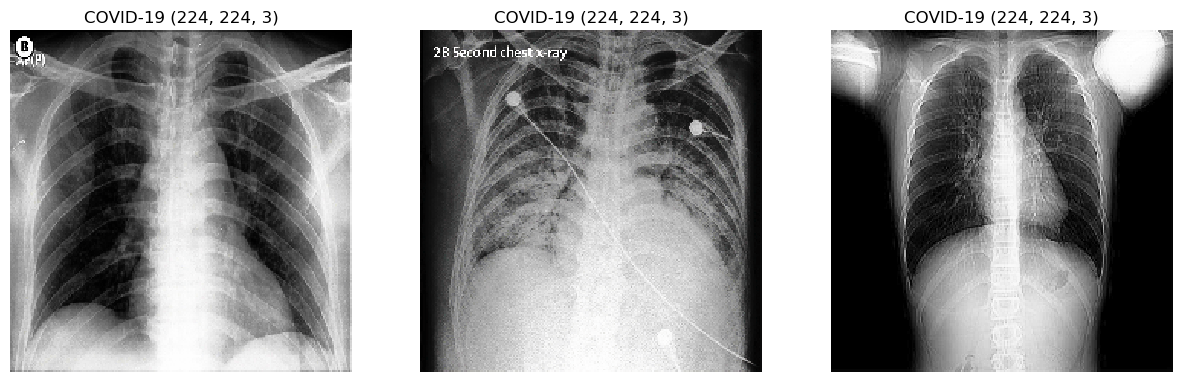

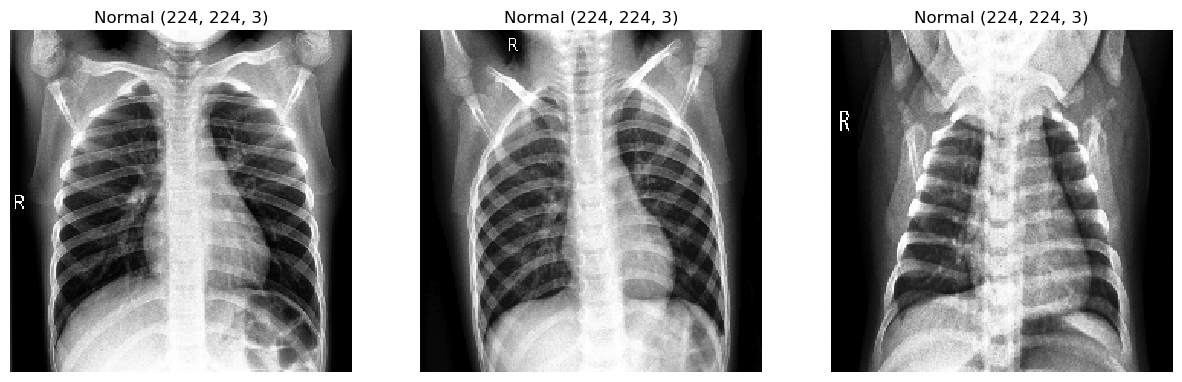

In [18]:
# Show random images that has COVID-19
show_images(random.sample(list(covid_image_arrs), 3), f"COVID-19 {covid_image_arrs[0].shape}")

# Show random images that are Normal
show_images(random.sample(list(normal_image_arrs), 3), f"Normal {normal_image_arrs[0].shape}")

## Exploring dominant colors / gray scale intensity of image 

In [21]:
import cv2
import numpy as np
from skimage import io

In [58]:
def get_dominant_colors(img):
    # calculate the mean of each chromatic channel 
    average = img.mean(axis=0).mean(axis=0)

    # Each pixels with RGB channels
    pixels = np.float32(img.reshape(-1, 3))

    # 5 dominant colors
    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # Using k-means clustering to create palette with the most representative gray intensity in image
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    # getting top 5 dominant colors
    dominant = palette[np.argmax(counts)]
    
    return average, dominant, palette

### Single example (Normal Image)

In [47]:
img = normal_image_arrs[0]
average, dominant, palette = get_dominant_colors(img)

print(f"average: {average}")
print(f"dominant: {dominant}")
print(f"palette: {palette}")

average: [105.23329879 105.23329879 105.23329879]
dominant: [5.700375 5.700375 5.700375]
palette: [[  5.700375   5.700375   5.700375]
 [111.7703   111.7703   111.7703  ]
 [225.68297  225.68297  225.68297 ]
 [ 58.022373  58.022373  58.022373]
 [167.34987  167.34987  167.34987 ]]


In [103]:
def show_colors(img, average, palette):
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
    rows = np.int_(img.shape[0]*freqs)

    dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
    print(f"average: {average}")
    print(f"palette: {palette}")
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
    ax0.imshow(avg_patch)
    ax0.set_title('Average color')
    ax0.axis('off')
    ax1.imshow(dom_patch)
    ax1.set_title('Dominant colors')
    ax1.axis('off')
    plt.show(fig)

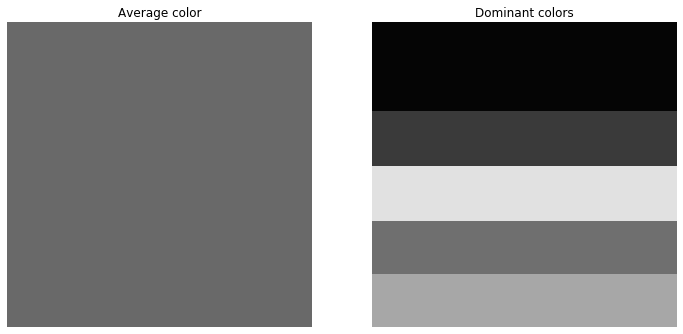

In [53]:
show_colors(img, average, palette)

## Normal image dominant colors

In [111]:
from tqdm.notebook import tqdm_notebook

results = []
for img in tqdm_notebook(normal_image_arrs):
    results.append(get_dominant_colors(img))
    
averages = np.zeros(shape=(3,))
dominants = np.zeros(shape=(3,))
palettes = np.zeros(shape=(5, 3))

for bundle in results:
    average, dominant, palette = bundle
    averages = averages + np.array(average)
    dominants = dominants + np.array(dominant)
    palettes = palettes + np.array(palette)

averages = averages / len(results)
dominants = dominants / len(results)
palettes = palettes / len(results)

/home/asuspro/anaconda3/envs/autoencoder/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


average: [118.7624437 118.7624437 118.7624437]
palette: [[127.70866036 127.70866036 127.70866036]
 [138.54741753 138.54741753 138.54741753]
 [130.06960429 130.06960429 130.06960429]
 [ 97.87827815  97.87827815  97.87827815]
 [115.31111903 115.31111903 115.31111903]]


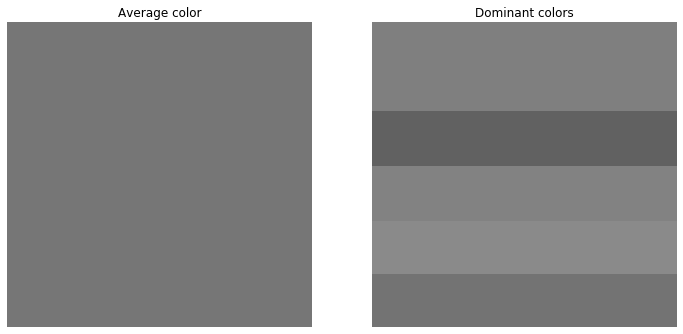

In [115]:
show_colors(img, averages, palettes)

## COVID image dominant colors

In [116]:
results = []
for img in tqdm_notebook(covid_image_arrs):
    results.append(get_dominant_colors(img))
    
averages = np.zeros(shape=(3,))
dominants = np.zeros(shape=(3,))
palettes = np.zeros(shape=(5, 3))

for bundle in results:
    average, dominant, palette = bundle
    averages = averages + np.array(average)
    dominants = dominants + np.array(dominant)
    palettes = palettes + np.array(palette)

averages = averages / len(results)
dominants = dominants / len(results)
palettes = palettes / len(results)

average: [125.74723202 125.77290528 125.79582279]
palette: [[127.84470418 127.77829285 127.81423683]
 [134.31717684 134.36724583 134.37779008]
 [135.58648173 135.52720901 137.28081589]
 [111.06630952 111.01102186 111.0256828 ]
 [123.37723468 123.44289813 123.46314809]]


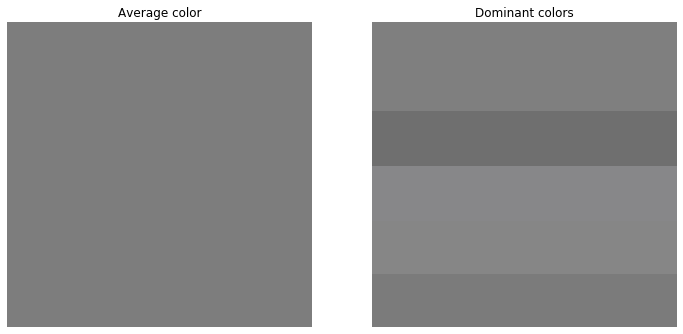

In [117]:
show_colors(img, averages, palettes)

This may partly explain why using only average pooling the result works so well.

Overall images which contain COVID19 have lighter shades of gray, the model learn to pick up lighter shades in overall image to determine it has COVID19.   

# Visualise how the image looks like after Pooling

In [146]:
from skimage.measure import block_reduce
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

## Image with COVID19

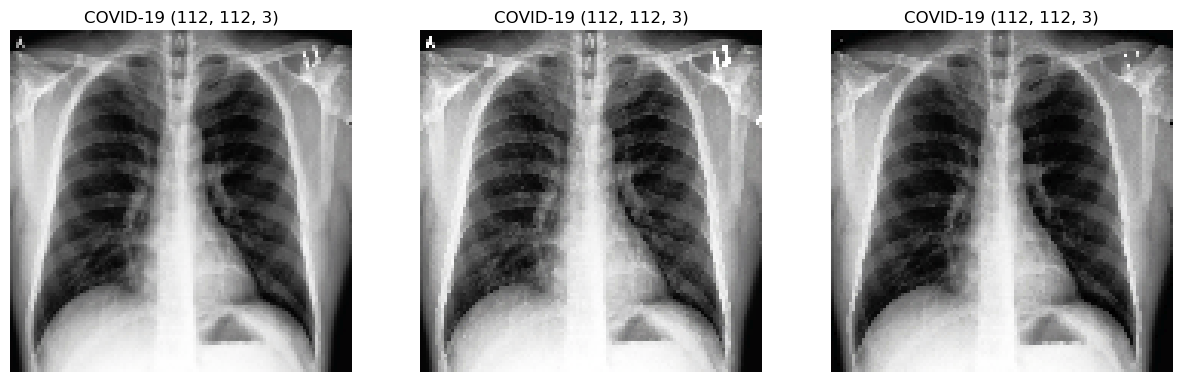

In [176]:
img = covid_image_arrs[11]
block_size = (2,2,1)

mean_pool = block_reduce(img, block_size=block_size, func=np.mean) / 255
max_pool = block_reduce(img, block_size=block_size, func=np.max) / 255
min_pool = block_reduce(img, block_size=block_size, func=np.min) / 255

show_images([mean_pool,max_pool,min_pool], f"COVID-19 {mean_pool.shape}")

## Image that are Normal 

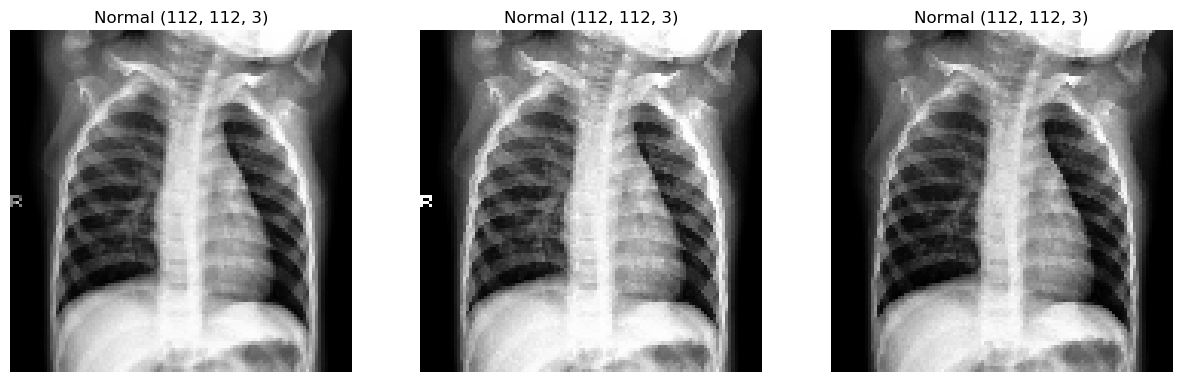

In [178]:
img = normal_image_arrs[8]

mean_pool = block_reduce(img, block_size=block_size, func=np.mean) / 255
max_pool = block_reduce(img, block_size=block_size, func=np.max) / 255
min_pool = block_reduce(img, block_size=block_size, func=np.min) / 255

show_images([mean_pool,max_pool,min_pool], f"Normal {mean_pool.shape}")